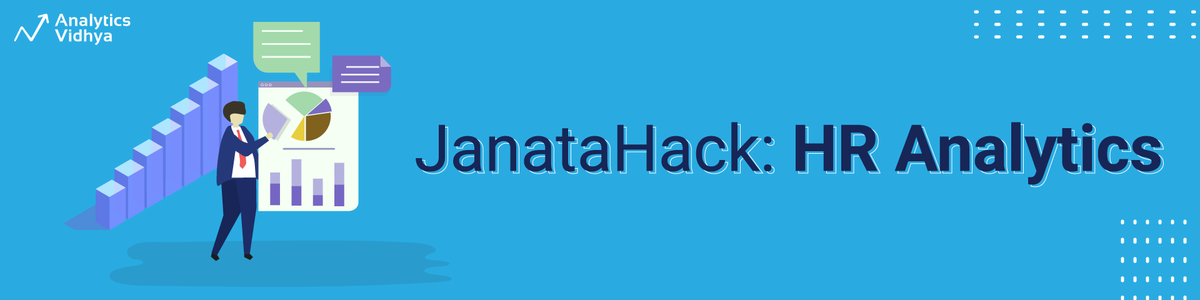


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import time
%matplotlib inline
# Classification
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from catboost import CatBoostClassifier,Pool, cv

# Preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from mlxtend.classifier import StackingClassifier
from datetime import datetime, timedelta
from sklearn.naive_bayes import MultinomialNB

import joblib
from sklearn.preprocessing import LabelEncoder

## Read data

In [2]:
test = pd.read_csv('../input/janatahack-hr-analytics/test.csv')
train = pd.read_csv('../input/janatahack-hr-analytics/train.csv')
print(test.shape,train.shape)

(15021, 13) (18359, 14)


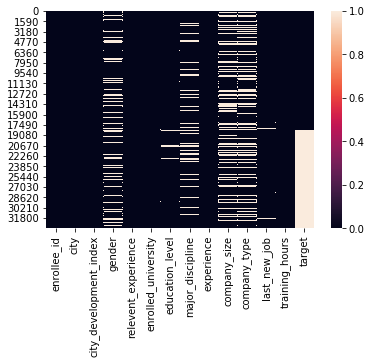

In [3]:
target = 'target'
test_ids = test['enrollee_id'] 
org_feat = train.columns
df=train.append(test,ignore_index=True)
sns.heatmap(df.isnull())

## Clean Data and Feature Engineering

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33380 entries, 0 to 33379
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             33380 non-null  int64  
 1   city                    33380 non-null  object 
 2   city_development_index  33380 non-null  float64
 3   gender                  25894 non-null  object 
 4   relevent_experience     33380 non-null  object 
 5   enrolled_university     32759 non-null  object 
 6   education_level         32528 non-null  object 
 7   major_discipline        28149 non-null  object 
 8   experience              33277 non-null  object 
 9   company_size            24550 non-null  object 
 10  company_type            24011 non-null  object 
 11  last_new_job            32709 non-null  object 
 12  training_hours          33380 non-null  int64  
 13  target                  18359 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
def logic_missing(df):
    df.loc[df['education_level'] == 'High School', 'major_discipline'] = 'not applicable'
    df.loc[df['education_level'] == 'Primary School', 'major_discipline'] = 'not applicable'
    df.loc[(df['experience']=='<1') & (df['company_type'].isna()) & (df['company_size'].isna()),'experience']=0
    df.loc[(df['experience']==0) & (df['company_type'].isna()) & (df['company_size'].isna()),'company_type']='Not Applicable'
    df.loc[(df['experience']==0) & (df['company_type']=='Not Applicable') & (df['company_size'].isna()),'company_size']='Not Applicable'
    return df

In [6]:
def impute_missing(df) : 
    missing_cols = list(df.columns[df.isnull().any()])
    print(f"Columns with missing values : {missing_cols}")
    df_org = df
    
    #### Impute Gender with unkniwn and add a _ismissing feature
    for col in missing_cols :
        if col!='target' :
            df[col+'_ismissing'] = 0
            df[col+'_ismissing'] = df[col].apply(lambda x : 1 if x!=x else 0) 
            df[col] = df[col].fillna('unknown')
        
    #df['gender'] = df['gender'].fillna('Unknown')
    return df

In [7]:
def cat_to_num(df) :
    df['company_size']=df['company_size'].apply(lambda x : 75 if x=='50-99' else x)
    df['company_size']=df['company_size'].apply(lambda x : 300 if x=='100-500' else x)
    df['company_size']=df['company_size'].apply(lambda x : 20000 if x=='10000+' else x)
    df['company_size']=df['company_size'].apply(lambda x : 30 if x=='10/49' else x)
    df['company_size']=df['company_size'].apply(lambda x : 3000 if x=='1000-4999' else x)
    df['company_size']=df['company_size'].apply(lambda x : 5 if x=='<10' else x)
    df['company_size']=df['company_size'].apply(lambda x : 750 if x=='500-999' else x)
    df['company_size']=df['company_size'].apply(lambda x : 7500 if x=='5000-9999' else x)
    df['company_size']=df['company_size'].apply(lambda x : -999 if x=='unknown' else x)
    df['company_size']=df['company_size'].apply(lambda x : -999 if x=='Not Applicable' else x)
    
    df['last_new_job'] = df['last_new_job'].apply(lambda x : 10 if x=='>4' else x)
    df['last_new_job'] = df['last_new_job'].apply(lambda x : 0 if x=='never' else x)
    df['last_new_job'] = df['last_new_job'].apply(lambda x : -999 if x=='unknown' else x)
    
    df['experience']=df['experience'].apply(lambda x : 0 if x=='<1' else x)
    df['experience']=df['experience'].apply(lambda x : 25 if x=='>20' else x)
    df['experience']=df['experience'].apply(lambda x : -999 if x=='unknown' else x)
    
    def ed_to_numeric(x):
        if x=='unknown' or x=='Primary School':
            return 0
        if x=='High School':
            return 1
        if x=='Graduate':
            return 2
        if x=='Masters':
            return 3
        if x=='Phd':
            return 4
    
    df['education_level'] = df['education_level'].apply(ed_to_numeric)
    
    df['last_new_job']=df['last_new_job'].astype(int)
    df['experience']=df['experience'].astype(int)
    #print(df['company_size'].value_counts())
    df['company_size']=df['company_size'].astype(int)

    
    return df

In [8]:
def feat_eng(df,cat) :
    df['experience_more_than20']=df['experience'].apply(lambda x : 1 if x>20 else 0)
    
    ##aggregate features
#     #cat_agg=['count','nunique']
#     num_agg=['min','mean','max','sum']
#     agg_col={
#         'experience':num_agg, 'company_size':num_agg, 'training_hours':num_agg,'last_new_job':num_agg}

#     agg_df=df.groupby('city').agg(agg_col)
#     agg_df.columns=['agg_' + '_'.join(col).strip() for col in agg_df.columns.values]
#     agg_df.reset_index(inplace=True)
    
#     df=df.merge(agg_df,on='city',how='left')
    
    ##ONE HOT ENCODING 
    if cat == 0:
        df=pd.get_dummies(df,columns=list(df.select_dtypes(include=['object']).columns),drop_first=True)
        cat_feat = 0
    else :
        cat_col = list(df.select_dtypes(include=['object']).columns)
        for c in cat_col :
            df[c] = df[c].astype('category')
        cat_feat = np.where(df.dtypes =='category')[0]

    return df,cat_feat

In [9]:
df_log = logic_missing(df)

In [10]:
df_imp = impute_missing(df_log)

Columns with missing values : ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'target']


In [11]:
df_num= cat_to_num(df_imp)

In [12]:
df_feat,cat_feat = feat_eng(df_num,0)

In [13]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33380 entries, 0 to 33379
Columns: 160 entries, enrollee_id to company_type_unknown
dtypes: float64(2), int64(15), uint8(143)
memory usage: 8.9 MB


In [14]:
df = df_feat.drop(columns = ['enrollee_id'])
cat_feat = cat_feat-1

## Data Prep


In [15]:
from imblearn.over_sampling import RandomOverSampler
os =RandomOverSampler(1)


df_train=df[df[target].isnull()==False].copy()
df_test=df[df[target].isnull()==True].copy()

df_test.drop(columns=[target],axis=1, inplace=True)

x = df_train.drop(target,axis=1)
y = df_train[target]
feat = df_test.columns

print(df_train.shape,df_test.shape)

x, y= os.fit_sample(x, y)

Using TensorFlow backend.


(18359, 159) (15021, 158)


In [16]:
def make_sub(y_pred,name):
    df_sub = pd.DataFrame({'enrollee_id':test_ids,target:y_pred})
    import time
    times = time.strftime("%Y%m%d-%H%M%S")
    filename = 'submission-'+name+'_'+times+'.csv'
    df_sub.to_csv(filename,index=False)
    print(f"{filename} generated!")

## Modelling

### LGB

In [17]:
def lgb_tune(x, y, target, plot=True):
    
    
    print("Parameter Tuning :")

    param_grid = {
    'num_leaves':[50],
    'max_depth':[-1],
    'colsample_bytree': [0.8],#,0.6,0.8],
    'min_child_samples': [10],#,10],
    'min_split_gain':[1],
    'subsample' : [0.7],
    'reg_alpha' : [0.7],#,0.6],
    'reg_lambda' : [0.6],#,0.7,0.8],
    'device': ['gpu']
    } 

    model = lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt', 
        learning_rate=0.003, 
        n_estimators=4000, 
        silent=False,
        #categorical_feature = cat_feat
    )
    
    skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 1001)
    
    lgb_grid = GridSearchCV(model, param_grid, cv=skf.split(x,y), scoring='roc_auc', verbose=1, n_jobs=4)
    lgb_grid.fit(x, y)

    print(lgb_grid.best_params_)
    print(lgb_grid.best_score_)

    #predictions = lgb_grid.predict(test[features]) 
    
    return lgb_grid.best_estimator_, #predictions, lgb_grid.best_params

In [18]:
def lgb_run (lgbM, cv) :
    err=[]
    y_pred_tot=[]
    from sklearn.model_selection import KFold,StratifiedKFold

    fold=StratifiedKFold(n_splits=cv,shuffle=True,random_state=1996)

    i=1

    for train_index, test_index in fold.split(x,y):
        print(f"\n\n-----------------FOLD {i}------------------------")
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        m=lgbM
        m.fit(x_train,y_train,eval_set=[(x_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=100)#,categorical_feature = cat_feat)
        preds=m.predict_proba(x_test)[:,-1]
        print("err: ",roc_auc_score(y_test,preds.round()))
        err.append(roc_auc_score(y_test,preds.round()))
        p = m.predict_proba(df_test[feat])[:,-1]
        i=i+1
        y_pred_tot.append(p)
    print (f"Mean score : {np.mean(err,0)}")
    y_pred_lgb = np.mean(y_pred_tot, 0)
    return y_pred_lgb

In [19]:
lgbM = lgb_tune(x, y, target, True)

Parameter Tuning :
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished


{'colsample_bytree': 0.8, 'device': 'gpu', 'max_depth': -1, 'min_child_samples': 10, 'min_split_gain': 1, 'num_leaves': 50, 'reg_alpha': 0.7, 'reg_lambda': 0.6, 'subsample': 0.7}
0.8031060266045351


In [20]:
y_pred_lgb= lgb_run (lgbM[0], 10)



-----------------FOLD 1------------------------
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.716768	valid_0's binary_logloss: 0.667215
[200]	valid_0's auc: 0.724722	valid_0's binary_logloss: 0.649832
[300]	valid_0's auc: 0.730803	valid_0's binary_logloss: 0.637337
[400]	valid_0's auc: 0.735909	valid_0's binary_logloss: 0.628002
[500]	valid_0's auc: 0.741719	valid_0's binary_logloss: 0.620382
[600]	valid_0's auc: 0.747305	valid_0's binary_logloss: 0.614147
[700]	valid_0's auc: 0.753689	valid_0's binary_logloss: 0.608135
[800]	valid_0's auc: 0.759711	valid_0's binary_logloss: 0.602788
[900]	valid_0's auc: 0.765156	valid_0's binary_logloss: 0.597977
[1000]	valid_0's auc: 0.770504	valid_0's binary_logloss: 0.593486
[1100]	valid_0's auc: 0.775228	valid_0's binary_logloss: 0.589449
[1200]	valid_0's auc: 0.779548	valid_0's binary_logloss: 0.585795
[1300]	valid_0's auc: 0.783647	valid_0's binary_logloss: 0.582277
[1400]	valid_0's auc: 0.787196	valid_0'

In [21]:
make_sub(y_pred_lgb,'lgb')

submission-lgb_20200510-182213.csv generated!


### XGB

In [22]:
def xgb_tune(x, y,  target):
    
    print("Parameter Tuning :")

    param_grid = {
    'max_depth':[3,6], ##
    'subsample':[0.8],
    'colsample_bytree': [1],
    'min_child_weight': [0.4],
    'gamma': [0.5],
    'reg_lambda': [1],
    } 

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.003, 
        n_estimators=4000, 
        tree_method = "gpu_hist",
        silent=False
    )

    skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 1001)

    xgb_grid = GridSearchCV(model, param_grid, cv=skf.split(x,y), scoring='roc_auc', verbose=1, n_jobs=4)
   
    xgb_grid.fit(x, y)

    print(xgb_grid.best_params_)
    print(xgb_grid.best_score_)


    return  xgb_grid.best_estimator_

In [23]:
def xgb_run (xgbM, cv) :
    err=[]
    y_pred_tot=[]
    from sklearn.model_selection import KFold,StratifiedKFold

    fold=StratifiedKFold(n_splits=cv,shuffle=True,random_state=1996)

    i=1

    for train_index, test_index in fold.split(x,y):

        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        m=xgbM
        m.fit(x_train,y_train,eval_set=[(x_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=100)
        preds=m.predict_proba(x_test)[:,-1]
        print("err: ",roc_auc_score(y_test,preds.round()))
        err.append(roc_auc_score(y_test,preds.round()))
        p = m.predict_proba(df_test[feat])[:,-1]
        i=i+1
        y_pred_tot.append(p)
    print (f"Mean score : {np.mean(err,0)}")
    y_pred_lgb = np.mean(y_pred_tot, 0)
    return y_pred_lgb

In [24]:
xgbM = xgb_tune(x, y, target)

Parameter Tuning :
Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:  2.8min finished


{'colsample_bytree': 1, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 0.4, 'reg_lambda': 1, 'subsample': 0.8}
0.8119071897053441


In [25]:
y_pred_xg= xgb_run (xgbM, 10)

[0]	validation_0-auc:0.68327
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.70469
[200]	validation_0-auc:0.70976
[300]	validation_0-auc:0.71495
[400]	validation_0-auc:0.72020
[500]	validation_0-auc:0.72566
[600]	validation_0-auc:0.73164
[700]	validation_0-auc:0.73720
[800]	validation_0-auc:0.74193
[900]	validation_0-auc:0.74606
[1000]	validation_0-auc:0.74980
[1100]	validation_0-auc:0.75344
[1200]	validation_0-auc:0.75660
[1300]	validation_0-auc:0.75958
[1400]	validation_0-auc:0.76244
[1500]	validation_0-auc:0.76466
[1600]	validation_0-auc:0.76716
[1700]	validation_0-auc:0.76933
[1800]	validation_0-auc:0.77160
[1900]	validation_0-auc:0.77382
[2000]	validation_0-auc:0.77587
[2100]	validation_0-auc:0.77797
[2200]	validation_0-auc:0.77985
[2300]	validation_0-auc:0.78186
[2400]	validation_0-auc:0.78367
[2500]	validation_0-auc:0.78571
[2600]	validation_0-auc:0.78754
[2700]	validation_0-auc:0.78948
[2800]	validation_0-auc:0.79122
[2900]	validation_0

In [26]:
make_sub(y_pred_xg,'xgb')

submission-xgb_20200510-182959.csv generated!


In [27]:
make_sub(y_pred_xg*0.5+y_pred_lgb*0.5,'xgblgb')

submission-xgblgb_20200510-182959.csv generated!
